# Fine-grained recognition using bilinear CNN with two VGG16 pipes

In [2]:
import tensorflow as tf

In [3]:
def outer_product(x):
    #Einstein Notation  [batch,height,width,depth] x [batch,height,width,depth] -> [batch,depth,depth]
    phi_I = tf.einsum('ijkm,ijkn->imn',x[0],x[1])
    
    # Reshape from [batch,depth,depth] to [batch, depth*depth]
    # Basically, flatten the outer matrix output
    phi_I = tf.reshape(phi_I,[-1,x[0].shape[3]*x[1].shape[3]])
    
    # Divide by feature map size [sizexsize]
    size1 = int(x[1].shape[1])
    size2 = int(x[1].shape[2])
    phi_I = tf.divide(phi_I, size1*size2)
    
    # Take signed square root of phi_I
    y_ssqrt = tf.multiply(tf.sign(phi_I),tf.sqrt(tf.abs(phi_I)+1e-12))
    
    # Apply l2 normalization
    z_l2 = tf.nn.l2_normalize(y_ssqrt, dim=1)
    return z_l2

## Import the base feature extraction model

In [4]:
vgg16 = tf.keras.applications.VGG16(
    include_top=False,
    input_shape=(96, 96, 3),
    weights="imagenet"
)

58900480/58889256 [==============================] - 3s 0us/step


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 96, 96, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
tf.nn.bias_add (TFOpLambda)     (None, 96, 96, 3)    0           tf.__operators__.getitem[0][0]   
__________________________________________________________________________________________________
CNN_A (Functional)              (None, 12, 12, 512)  7635264     tf.nn.bias_add[0][0]             
______________________________________________________________________________________________

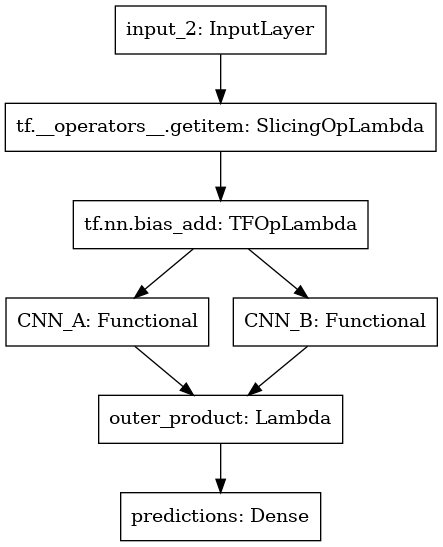

In [5]:
# Cut off the CNN model
f = vgg16.get_layer("block4_conv3").output

# Build the two CNN submodels
cnn_a = tf.keras.Model(vgg16.input, f, name="CNN_A")
cnn_b = tf.keras.Model(vgg16.input, f, name="CNN_B")

# --------------------------------------------------
inputs = tf.keras.Input(shape=(96, 96, 3))
x = tf.keras.applications.vgg16.preprocess_input(inputs)

fa = cnn_a(x)
fb = cnn_b(x)

# Apply bilinear pooling on both CNN outputs
bilinear_features = tf.keras.layers.Lambda(
    outer_product, name="outer_product"
)([fa, fb])

# Densely connect the bilinear feature vector to the output layer with softmax activation
# Note: no regularization method used and no intermediate FC layer
outputs = tf.keras.layers.Dense(
    8, activation="softmax", name="predictions"
)(bilinear_features)

bilinear_model = tf.keras.Model(inputs, outputs)

# We will first freeze the CNN parts
cnn_a.trainable = False
cnn_b.trainable = False

bilinear_model.summary()
tf.keras.utils.plot_model(bilinear_model)

# First round: train only the final dense "predictions" layer

## Create a "heavy augmentation" data pipeline

In [6]:
from keras_preprocessing.image import ImageDataGenerator
data_gen = ImageDataGenerator(
    rotation_range=45.,  # Max rotation in degrees
    zoom_range=0.3,  # Max zoom
    width_shift_range=15,  # Horizontal shift (in pixels)
    height_shift_range=15,  # Vertical shift (in pixels)
    horizontal_flip=True,  # Horizontal flip
    vertical_flip=True,  # Vertical flip
    brightness_range=[0.5, 1.5],  # Minimum and max brightness scaling
    shear_range=10.,  # Max shear in degrees
    fill_mode="reflect",  # Filling method for out-ofµ-border pixels
    validation_split=0.15
)

rng_seed = 20450

train_data = data_gen.flow_from_directory(
    "../input/flowerspeciesclassification/images",
    target_size=(96, 96),
    subset="training",
    seed=rng_seed
)

val_data = data_gen.flow_from_directory(
    "../input/flowerspeciesclassification/images",
    target_size=(96, 96),
    subset="validation",
    seed=rng_seed
)

Found 3015 images belonging to 8 classes.
Found 527 images belonging to 8 classes.


## Fit the dense layer with a "standard" learning rate and frozen CNN

In [7]:
bilinear_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics='accuracy'
)

bilinear_model.fit(
    train_data,
    epochs=80,
    validation_data=val_data,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
        tf.keras.callbacks.TensorBoard(
            log_dir="tensorboard_logs", 
            profile_batch=0,
            histogram_freq=1
        )  # if > 0 (epochs) shows weights histograms
    ]
)

2022-11-21 15:59:34.000147: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/80


2022-11-21 15:59:35.922365: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


95/95 [==============================] - 42s 366ms/step - loss: 1.5677 - accuracy: 0.4769 - val_loss: 1.3296 - val_accuracy: 0.5313
Epoch 2/80
95/95 [==============================] - 14s 150ms/step - loss: 1.2315 - accuracy: 0.5924 - val_loss: 1.2032 - val_accuracy: 0.5901
Epoch 3/80
95/95 [==============================] - 15s 158ms/step - loss: 1.1149 - accuracy: 0.6219 - val_loss: 1.1173 - val_accuracy: 0.6243
Epoch 4/80
95/95 [==============================] - 15s 156ms/step - loss: 1.0384 - accuracy: 0.6484 - val_loss: 1.0515 - val_accuracy: 0.6262
Epoch 5/80
95/95 [==============================] - 14s 148ms/step - loss: 0.9726 - accuracy: 0.6633 - val_loss: 1.0179 - val_accuracy: 0.6433
Epoch 6/80
95/95 [==============================] - 15s 156ms/step - loss: 0.9427 - accuracy: 0.6793 - val_loss: 0.9730 - val_accuracy: 0.6376
Epoch 7/80
95/95 [==============================] - 14s 150ms/step - loss: 0.9227 - accuracy: 0.6892 - val_loss: 0.9328 - val_accuracy: 0.6622
Epoch 8/80

## Save progress

In [3]:
import shutil

# Save the model
bilinear_model.save("bilinearCNN")
shutil.make_archive("bilinearCNN", "zip", "bilinearCNN")

In [5]:
# Save the training logs
shutil.make_archive("tensorboard_logs_bilinearCNN_frozen", "zip", "tensorboard_logs")

'/kaggle/working/tensorboard_logs_bilinearCNN_frozen.zip'

# Fine-tuning on the unfrozen convolutional part of the model

We will proceed to unfreeze the two convolutional pipes of the network and train the model again with learning rate set to a low value to allow for fine tuning of these said convolutional models.  

## Round 1
### Unfreeze the CNN parts and train the model at a lower learning rate

In [10]:
cnn_a.trainable = True
cnn_b.trainable = True

bilinear_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics='accuracy'
)

bilinear_model.fit(
    train_data,
    epochs=200,
    validation_data=val_data,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tf.keras.callbacks.TensorBoard(
            log_dir="tensorboard_logs_bilinearCNN_full", 
            profile_batch=0,
            histogram_freq=1
        )  # if > 0 (epochs) shows weights histograms
    ]
)

Epoch 1/200
95/95 [==============================] - 18s 173ms/step - loss: 0.6267 - accuracy: 0.7871 - val_loss: 0.6899 - val_accuracy: 0.7533
Epoch 2/200
95/95 [==============================] - 16s 164ms/step - loss: 0.5571 - accuracy: 0.8010 - val_loss: 0.6446 - val_accuracy: 0.7704
Epoch 3/200
95/95 [==============================] - 16s 165ms/step - loss: 0.5285 - accuracy: 0.8156 - val_loss: 0.5840 - val_accuracy: 0.7894
Epoch 4/200
95/95 [==============================] - 17s 179ms/step - loss: 0.4996 - accuracy: 0.8232 - val_loss: 0.6167 - val_accuracy: 0.7590
Epoch 5/200
95/95 [==============================] - 16s 167ms/step - loss: 0.4677 - accuracy: 0.8335 - val_loss: 0.6162 - val_accuracy: 0.7970
Epoch 6/200
95/95 [==============================] - 17s 174ms/step - loss: 0.4574 - accuracy: 0.8444 - val_loss: 0.5666 - val_accuracy: 0.7913
Epoch 7/200
95/95 [==============================] - 16s 168ms/step - loss: 0.4467 - accuracy: 0.8461 - val_loss: 0.5392 - val_accuracy:

In [12]:
# Save model
bilinear_model.save("bilinearCNN_full")
shutil.make_archive("bilinearCNN_full", "zip", "bilinearCNN_full")

'/kaggle/working/bilinearCNN_full.zip'

In [6]:
# Save the training logs
shutil.make_archive("tensorboard_logs_bilinearCNN_full", "zip", "tensorboard_logs_bilinearCNN_full")

'/kaggle/working/tensorboard_logs_bilinearCNN_full.zip'

## Round 2

Now that the first round of fine-tuning has somewhat converged (well, that the validation accuracy stopped increasing anyway), we can help the model make additional progress by reducing the variance in the training data. Effectively, as it is now, the data augmentation is such that the remaining convergence that could be done is overwhelmed by the noise that's generated from data augmentation. We want to slowly reduce the effect of data augmentation being in the way of the model's convergence. However, doing that, we're at the risk of overwriting the high variance - low bias training that has been done before, i.e eventually at the risk of overfitting, despite the efforts that have been made to avoid it through data augmentation. Therefore, it is important that we reduce the learning rate again so that we don't completely overwrite the past rounds of training.

### A more "gentle" data augmentation pipeline

In [14]:
data_gen = ImageDataGenerator(
    rotation_range=30.,  # Max rotation in degrees
    zoom_range=0.15,  # Max zoom
    width_shift_range=8,  # Horizontal shift (in pixels)
    height_shift_range=8,  # Vertical shift (in pixels)
    horizontal_flip=True,  # Horizontal flip
    vertical_flip=False,  # Vertical flip
    brightness_range=[0.8, 1.2],  # Minimum and max brightness scaling
    shear_range=5.,  # Max shear in degrees
    fill_mode="reflect",  # Filling method for out-ofµ-border pixels
    validation_split=0.15
)

rng_seed = 20450

train_data = data_gen.flow_from_directory(
    "../input/flowerspeciesclassification/images",
    target_size=(96, 96),
    subset="training",
    seed=rng_seed
)

val_data = data_gen.flow_from_directory(
    "../input/flowerspeciesclassification/images",
    target_size=(96, 96),
    subset="validation",
    seed=rng_seed
)

Found 3015 images belonging to 8 classes.
Found 527 images belonging to 8 classes.


### Fine-tuning with an even lower learning rate = 1e-6

In [16]:
bilinear_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-6),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics='accuracy'
)

bilinear_model.fit(
    train_data,
    epochs=200,
    validation_data=val_data,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tf.keras.callbacks.TensorBoard(
            log_dir="tensorboard_logs_bilinearCNN_full_2", 
            profile_batch=0,
            histogram_freq=1
        )  # if > 0 (epochs) shows weights histograms
    ]
)

Epoch 1/200
95/95 [==============================] - 17s 167ms/step - loss: 0.0246 - accuracy: 0.9973 - val_loss: 0.3098 - val_accuracy: 0.9146
Epoch 2/200
95/95 [==============================] - 16s 167ms/step - loss: 0.0228 - accuracy: 0.9980 - val_loss: 0.2823 - val_accuracy: 0.9089
Epoch 3/200
95/95 [==============================] - 15s 162ms/step - loss: 0.0212 - accuracy: 0.9983 - val_loss: 0.3235 - val_accuracy: 0.9089
Epoch 4/200
95/95 [==============================] - 16s 171ms/step - loss: 0.0196 - accuracy: 0.9987 - val_loss: 0.3405 - val_accuracy: 0.8937
Epoch 5/200
95/95 [==============================] - 16s 170ms/step - loss: 0.0206 - accuracy: 0.9993 - val_loss: 0.3089 - val_accuracy: 0.9089
Epoch 6/200
95/95 [==============================] - 16s 163ms/step - loss: 0.0189 - accuracy: 0.9990 - val_loss: 0.2897 - val_accuracy: 0.9127
Epoch 7/200
95/95 [==============================] - 16s 170ms/step - loss: 0.0187 - accuracy: 0.9990 - val_loss: 0.2863 - val_accuracy:

In [17]:
bilinear_model.save("bilinearCNN_full_2")
shutil.make_archive("bilinearCNN_full_2", "zip", "bilinearCNN_full_2")

'/kaggle/working/bilinearCNN_full_2.zip'

In [18]:
data_gen = ImageDataGenerator(
    rotation_range=15.,  # Max rotation in degrees
    zoom_range=0.1,  # Max zoom
    width_shift_range=4,  # Horizontal shift (in pixels)
    height_shift_range=4,  # Vertical shift (in pixels)
    horizontal_flip=True,  # Horizontal flip
    vertical_flip=False,  # Vertical flip
    brightness_range=[0.9, 1.1],  # Minimum and max brightness scaling
    fill_mode="reflect",  # Filling method for out-ofµ-border pixels
    validation_split=0.15
)

rng_seed = 20450

train_data = data_gen.flow_from_directory(
    "../input/flowerspeciesclassification/images",
    target_size=(96, 96),
    subset="training",
    seed=rng_seed
)

val_data = data_gen.flow_from_directory(
    "../input/flowerspeciesclassification/images",
    target_size=(96, 96),
    subset="validation",
    seed=rng_seed
)

Found 3015 images belonging to 8 classes.
Found 527 images belonging to 8 classes.


In [19]:
bilinear_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-6),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics='accuracy'
)

bilinear_model.fit(
    train_data,
    epochs=200,
    validation_data=val_data,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tf.keras.callbacks.TensorBoard(
            log_dir="tensorboard_logs_bilinearCNN_full_3", 
            profile_batch=0,
            histogram_freq=1
        )  # if > 0 (epochs) shows weights histograms
    ]
)

Epoch 1/200
95/95 [==============================] - 17s 168ms/step - loss: 0.0140 - accuracy: 0.9993 - val_loss: 0.3056 - val_accuracy: 0.9013
Epoch 2/200
95/95 [==============================] - 15s 159ms/step - loss: 0.0131 - accuracy: 0.9997 - val_loss: 0.3184 - val_accuracy: 0.9184
Epoch 3/200
95/95 [==============================] - 16s 164ms/step - loss: 0.0125 - accuracy: 1.0000 - val_loss: 0.3216 - val_accuracy: 0.8937
Epoch 4/200
95/95 [==============================] - 16s 172ms/step - loss: 0.0136 - accuracy: 0.9997 - val_loss: 0.2917 - val_accuracy: 0.9184
Epoch 5/200
95/95 [==============================] - 15s 162ms/step - loss: 0.0140 - accuracy: 0.9997 - val_loss: 0.3091 - val_accuracy: 0.9203
Epoch 6/200
95/95 [==============================] - 16s 167ms/step - loss: 0.0138 - accuracy: 0.9987 - val_loss: 0.3033 - val_accuracy: 0.9013
Epoch 7/200
95/95 [==============================] - 16s 167ms/step - loss: 0.0131 - accuracy: 0.9997 - val_loss: 0.3010 - val_accuracy:

In [20]:
bilinear_model.save("bilinearCNN_full_3")
shutil.make_archive("bilinearCNN_full_3", "zip", "bilinearCNN_full_3")

'/kaggle/working/bilinearCNN_full_3.zip'

In [21]:
data_gen = ImageDataGenerator(
    horizontal_flip=True,  # Horizontal flip
    brightness_range=[0.9, 1.1],  # Minimum and max brightness scaling
    fill_mode="reflect",  # Filling method for out-ofµ-border pixels
    validation_split=0.15
)

rng_seed = 20450

train_data = data_gen.flow_from_directory(
    "../input/flowerspeciesclassification/images",
    target_size=(96, 96),
    subset="training",
    seed=rng_seed
)

val_data = data_gen.flow_from_directory(
    "../input/flowerspeciesclassification/images",
    target_size=(96, 96),
    subset="validation",
    seed=rng_seed
)

Found 3015 images belonging to 8 classes.
Found 527 images belonging to 8 classes.


In [22]:
bilinear_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-7),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics='accuracy'
)

bilinear_model.fit(
    train_data,
    epochs=200,
    validation_data=val_data,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tf.keras.callbacks.TensorBoard(
            log_dir="tensorboard_logs_bilinearCNN_full_4", 
            profile_batch=0,
            histogram_freq=1
        )  # if > 0 (epochs) shows weights histograms
    ]
)

Epoch 1/200
95/95 [==============================] - 10s 99ms/step - loss: 0.0459 - accuracy: 0.9867 - val_loss: 0.3746 - val_accuracy: 0.9013
Epoch 2/200
95/95 [==============================] - 9s 93ms/step - loss: 0.0303 - accuracy: 0.9937 - val_loss: 0.3519 - val_accuracy: 0.8994
Epoch 3/200
95/95 [==============================] - 9s 93ms/step - loss: 0.0249 - accuracy: 0.9960 - val_loss: 0.3370 - val_accuracy: 0.8994
Epoch 4/200
95/95 [==============================] - 9s 94ms/step - loss: 0.0201 - accuracy: 0.9973 - val_loss: 0.3292 - val_accuracy: 0.8994
Epoch 5/200
95/95 [==============================] - 9s 94ms/step - loss: 0.0166 - accuracy: 0.9993 - val_loss: 0.3376 - val_accuracy: 0.9032
Epoch 6/200
95/95 [==============================] - 9s 96ms/step - loss: 0.0154 - accuracy: 0.9993 - val_loss: 0.3260 - val_accuracy: 0.9089
Epoch 7/200
95/95 [==============================] - 9s 93ms/step - loss: 0.0131 - accuracy: 1.0000 - val_loss: 0.3114 - val_accuracy: 0.9108
Epoch

In [23]:
bilinear_model.save("bilinearCNN_full_4")
shutil.make_archive("bilinearCNN_full_4", "zip", "bilinearCNN_full_4")

'/kaggle/working/bilinearCNN_full_4.zip'